In [76]:
import pandas as pd
from stable_baselines3.common.logger import configure

from finrl.agents.stablebaselines3.models import DRLAgent as StockDRLAgent
from finrl.agents.portfolio_optimization.models import DRLAgent as OptDRLAgent
from finrl.agents.portfolio_optimization.models_stable import DRLStableAgent

from finrl.config import TRAINED_MODEL_DIR, RESULTS_DIR
from finrl.main import check_and_make_directories
from finrl.meta.env_stock_trading.env_stocktrading import StockTradingEnv

import numpy as np


TIME_WINDOW = 50
COMMISSION_FEE_PERCENT = 0.001
INITIAL_CASH = 1000000

# HISTORY DATA FOR SCRP
HISTORY_START_DATE = '2010-01-01'

TEST_START_DATE = '2015-01-01'
TEST_END_DATE = '2017-12-31'

EIIE_MODEL = "trained_eiie/policy_EIIE_2014-12-31_3_2024-11-29 21_11_47.pt"

GRAPH_TITLE = "EIIE Trained 2009-2014, 40 episodes"

# Backtest the results

from finrl.meta.preprocessor.yahoodownloader import YahooDownloader

TEST_TICKER = [
   "AMZN",
    "NKE",
    "DIS",
    "JPM",
    "IBM",
    "NVDA",
]

PORT = TEST_TICKER

df = YahooDownloader(start_date = TEST_START_DATE,
                     end_date = TEST_END_DATE,
                     ticker_list = PORT).fetch_data()

processed = df.copy()
processed = processed.fillna(0)
processed_test = processed.replace(np.inf,0)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Shape of DataFrame:  (4530, 8)


# Portfolio Optimization Algorithm

In [77]:
from finrl.meta.env_portfolio_optimization.env_portfolio_optimization import PortfolioOptimizationEnv


# Fit for the portfolio optimization model

from sklearn.preprocessing import MaxAbsScaler
from finrl.meta.preprocessor.preprocessors import GroupByScaler

portfolio_norm_df = GroupByScaler(by="tic", scaler=MaxAbsScaler).fit_transform(processed_test)
portfolio_norm_df


environment = PortfolioOptimizationEnv(
    portfolio_norm_df,
    initial_amount=INITIAL_CASH,
    comission_fee_pct=COMMISSION_FEE_PERCENT,
    time_window=TIME_WINDOW,
    features=["close", "high", "low"],
    normalize_df=None
)

c:\Users\bencj\Desktop\Econ4\Thesis\.venv\lib\site-packages\finrl\meta\preprocessor\preprocessors.py:101: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[0.11666618 0.11628892 0.14750944 0.1106761  0.12945955 0.10866822
 0.14341825 0.17338962 0.23217123 0.18524403 0.14579919 0.12890204
 0.42190886 0.22478947 0.1884801  0.13286748 0.12241314 0.12842837
 0.36286736 1.         0.42890078 0.26041977 0.17479387 0.3038049
 0.16316162 0.11420978 0.09587485 0.11680451 0.11699733 0.14566924
 0.1539732  0.11110785 0.12381739 0.13656884 0.09125549 0.08051609
 0.13306869 0.11263786 0.10614895 0.08967099 0.08159339 0.09469695
 0.11290613 0.11011859 0.09688927 0.13082608 0.1045896  0.11778958
 0.10947724 0.09867916 0.08538697 0.11125456 0.08030231 0.15776258
 0.09386698 0.09340169 0.14375778 0.12281974 0.1093976  0.07632849
 0.1050507  0.10303864 0.07860883 0.12787924 0.0819455  0.11051262
 0.10028043 0.10787597 0.0794

In [78]:
import torch
from finrl.agents.portfolio_optimization.architectures import EIIE

device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

# set PolicyGradient parameters
model_kwargs = {
    "lr": 0.01,
    "policy": EIIE,
}

# here, we can set EIIE's parameters
policy_kwargs = {
    "k_size": 3,
    "time_window": TIME_WINDOW,
}


# instantiate an architecture with the same arguments used in training
# and load with load_state_dict.
policy = EIIE(time_window=TIME_WINDOW, device=device)
policy.load_state_dict(torch.load(EIIE_MODEL, map_location=torch.device('cpu')))

C:\Users\bencj\AppData\Local\Temp\ipykernel_11508\2633074032.py:22: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  policy.load_state_dict(torch.load(EIIE_MODEL, map_location=

<All keys matched successfully>

In [79]:
EIIE_results = {
    "test": {},
}

# 2021 - 2024
# Initialize the model
model = OptDRLAgent(environment).get_model("pg", device, model_kwargs, policy_kwargs)
OptDRLAgent.DRL_validation(model, environment, policy=policy)
EIIE_results["test"]["value"] = environment._asset_memory["final"]
EIIE_results["test"]["date"] = environment._date_memory



# Write this out to a csv file, with date and net worth
df_opt = pd.DataFrame(EIIE_results["test"]["value"], columns=['eiie_net_worth'])
df_date = pd.DataFrame(EIIE_results["test"]["date"], columns=['Date'])
if len(df_opt) == len(df_date):
    df_opt['Date'] = df_date['Date']
else:
    raise ValueError("DataFrames do not have the same number of rows.")


# The optimization algoirhtm has a shorter window than the full df, so shorted this for the follow algorithm
opt_start = df_opt.loc[0,'Date']


Initial portfolio value:1000000
Final portfolio value: 6025591.5
Final accumulative portfolio value: 6.0255915
Maximum DrawDown: -0.21742791948499696
Sharpe ratio: 2.082666672866736
Total commission cost: 40117.53542517696


In [80]:
print(df_opt)

     eiie_net_worth       Date
0      1.000000e+06 2015-03-16
1      1.005683e+06 2015-03-17
2      1.000155e+06 2015-03-18
3      1.006696e+06 2015-03-19
4      1.019516e+06 2015-03-20
..              ...        ...
701    6.051617e+06 2017-12-22
702    6.059638e+06 2017-12-26
703    6.041970e+06 2017-12-27
704    6.059076e+06 2017-12-28
705    6.025592e+06 2017-12-29

[706 rows x 2 columns]


In [81]:
opt_end = df_opt.loc[len(df_date)-1,'Date']

print(opt_start)
opt_start = opt_start.strftime('%Y-%m-%d %H:%M:%S')


print(opt_end)
opt_end = opt_end.strftime('%Y-%m-%d %H:%M:%S')

2015-03-16 00:00:00
2017-12-29 00:00:00


In [82]:
from sklearn.preprocessing import MaxAbsScaler
from finrl.meta.preprocessor.preprocessors import GroupByScaler

from finrl.meta.preprocessor.preprocessors import data_split

from datetime import datetime, timedelta
# Make sure dates line up
# Make sure we only test on the same data as the portfolio optimization algorithm
# Convert to datetime
opt_start_date = datetime.strptime(opt_start, '%Y-%m-%d %H:%M:%S')

# Subtract one day
new_opt_start_date = opt_start_date - timedelta(days=1)

# Convert back to string
new_opt_start_str = new_opt_start_date.strftime('%Y-%m-%d %H:%M:%S')

test_split = data_split(processed_test, new_opt_start_str,opt_end)

# DONT NORMALIZE PRICES FOR benchmarks with history
environment_benchmarks = PortfolioOptimizationEnv(
    test_split,
    initial_amount=INITIAL_CASH,
    comission_fee_pct=COMMISSION_FEE_PERCENT,
    # time_window=TIME_WINDOW,
    features=["close", "high", "low"],
    normalize_df=None
)



# PPO Model

In [83]:
from stable_baselines3 import PPO
from finrl.config import TRAINED_MODEL_DIR

TRAINED_PPO = "/train_2009-2015/trained_models/agent_opt_ppo_update_test"

test_ppo_norm_df = GroupByScaler(by="tic", scaler=MaxAbsScaler).fit_transform(test_split)


trained_ppo_opt = PPO.load(TRAINED_MODEL_DIR + TRAINED_PPO) 


environment_ppo = PortfolioOptimizationEnv(
    test_ppo_norm_df,
    initial_amount=INITIAL_CASH,
    comission_fee_pct=COMMISSION_FEE_PERCENT,
    # time_window=TIME_WINDOW,
    features=["close", "high", "low"],
    normalize_df=None
)

PPO_results = {
    "test": {},
}

values, dates = DRLStableAgent.DRL_prediction(trained_ppo_opt, environment_ppo, deterministic=True)
PPO_results["test"]["value"] = environment_ppo._terminal_asset_memory["final"]
PPO_results["test"]["date"] = environment_ppo._terminal_date_memory


# Write this out to a csv file, with date and net worth
df_ppo_opt = pd.DataFrame(PPO_results["test"]["value"], columns=['ppo_opt_net_worth'])
df_ppo_date = pd.DataFrame(PPO_results["test"]["date"], columns=['Date'])
if len(df_ppo_opt) == len(df_ppo_date):
    df_ppo_opt['Date'] = df_ppo_date['Date']
else:
    raise ValueError("DataFrames do not have the same number of rows.")

print(df_ppo_opt)

c:\Users\bencj\Desktop\Econ4\Thesis\.venv\lib\site-packages\finrl\meta\preprocessor\preprocessors.py:101: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[0.10744703 0.09297379 0.12113978 0.08743736 0.17178015 0.10220727
 0.10170064 0.15653099 0.13373255 0.11911782 0.08311045 0.11438469
 0.11219385 0.0855934  0.1392416  0.08922654 0.12033191 0.10919058
 0.117461   0.08646973 0.11792199 0.0882361  0.09495468 0.17525354
 0.22894739 0.21194099 0.15859403 0.36422723 0.78399682 0.24787991
 0.18898281 0.16530348 0.16649931 0.16275206 0.10362675 0.13037326
 0.11650251 0.12625175 0.13276493 0.10925448 0.08890248 0.09111614
 0.08619588 0.19353793 0.10909473 0.11247227 0.10024008 0.18811104
 0.09222525 0.10243092 0.101833   0.08728674 0.13766237 0.10284627
 0.07617278 0.1245082  0.11459921 0.08708134 0.09915835 0.10446201
 0.09914922 0.13339023 0.09376797 0.09361279 0.10481346 0.09976996
 0.15419865 0.20516764 0.083

Initial portfolio value:1000000
Final portfolio value: 1855729.5
Final accumulative portfolio value: 1.8557295
Maximum DrawDown: -0.2287178915120136
Sharpe ratio: 1.1626779753364909
Total commission cost: 511.17417497665156
hit end!
     ppo_opt_net_worth       Date
0         1.000000e+06 2015-03-16
1         9.961763e+05 2015-03-17
2         9.985269e+05 2015-03-18
3         9.898298e+05 2015-03-19
4         9.990419e+05 2015-03-20
..                 ...        ...
701       1.864722e+06 2017-12-22
702       1.857458e+06 2017-12-26
703       1.860666e+06 2017-12-27
704       1.870448e+06 2017-12-28
705       1.855730e+06 2017-12-29

[706 rows x 2 columns]


# Porfolio Baselines

In [84]:
# CRP 

CRP_results = {
    "test": {},
}

environment_benchmarks.reset()
agent_crp = DRLStableAgent(env = environment_benchmarks)
model_crp = agent_crp.get_model("crp", None, None)

values, dates = DRLStableAgent.DRL_prediction(model_crp, environment_benchmarks)
CRP_results["test"]["value"] = environment_benchmarks._terminal_asset_memory["final"]
CRP_results["test"]["date"] = environment_benchmarks._terminal_date_memory

df_crp_opt = pd.DataFrame(CRP_results["test"]["value"], columns=['crp_opt_net_worth'])
df_crp_date = pd.DataFrame(CRP_results["test"]["date"], columns=['Date'])
if len(df_crp_opt) == len(df_crp_date):
    df_crp_opt['Date'] = df_crp_date['Date']
else:
    raise ValueError("DataFrames do not have the same number of rows.")

print(df_crp_opt)


# assert the dates line up
assert df_opt.loc[0,'Date'] == df_crp_opt.loc[0, 'Date']
assert df_opt.loc[len(df_date)-1,'Date'] == df_crp_opt.loc[len(df_crp_opt)-1,'Date']

c:\Users\bencj\Desktop\Econ4\Thesis\.venv\lib\site-packages\stable_baselines3\common\vec_env\patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(


Initial portfolio value:1000000
Final portfolio value: 2171344.0
Final accumulative portfolio value: 2.171344
Maximum DrawDown: -0.20120393524489477
Sharpe ratio: 1.8196038420864495
Total commission cost: 8520.623782240786
hit end!
     crp_opt_net_worth       Date
0         1.000000e+06 2015-03-16
1         1.000156e+06 2015-03-17
2         1.005524e+06 2015-03-18
3         1.006200e+06 2015-03-19
4         1.022984e+06 2015-03-20
..                 ...        ...
701       2.181933e+06 2017-12-22
702       2.188135e+06 2017-12-26
703       2.185097e+06 2017-12-27
704       2.191236e+06 2017-12-28
705       2.171344e+06 2017-12-29

[706 rows x 2 columns]


In [85]:
# BAH

BAH_results = {
    "test": {},
}

environment_benchmarks.reset()
agent_bah = DRLStableAgent(env = environment_benchmarks)
model_bah = agent_bah.get_model("bah", None, None)

values, dates = DRLStableAgent.DRL_prediction(model_bah, environment_benchmarks)
BAH_results["test"]["value"] = environment_benchmarks._terminal_asset_memory["final"]
BAH_results["test"]["date"] = environment_benchmarks._terminal_date_memory

df_bah_opt = pd.DataFrame(BAH_results["test"]["value"], columns=['bah_opt_net_worth'])
df_bah_date = pd.DataFrame(BAH_results["test"]["date"], columns=['Date'])
if len(df_bah_opt) == len(df_bah_date):
    df_bah_opt['Date'] = df_bah_date['Date']
else:
    raise ValueError("DataFrames do not have the same number of rows.")

print(df_bah_opt)


# assert the dates line up
assert df_opt.loc[0,'Date'] == df_bah_opt.loc[0, 'Date']
assert df_opt.loc[len(df_date)-1,'Date'] == df_bah_opt.loc[len(df_bah_opt)-1,'Date']

c:\Users\bencj\Desktop\Econ4\Thesis\.venv\lib\site-packages\stable_baselines3\common\vec_env\patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(


Initial portfolio value:1000000
Final portfolio value: 2850360.5
Final accumulative portfolio value: 2.8503605
Maximum DrawDown: -0.20971406542407167
Sharpe ratio: 1.9460458165972667
Total commission cost: 0.0
hit end!
     bah_opt_net_worth       Date
0         1.000000e+06 2015-03-16
1         1.000156e+06 2015-03-17
2         1.005481e+06 2015-03-18
3         1.006159e+06 2015-03-19
4         1.023026e+06 2015-03-20
..                 ...        ...
701       2.867966e+06 2017-12-22
702       2.887414e+06 2017-12-26
703       2.885512e+06 2017-12-27
704       2.891867e+06 2017-12-28
705       2.850360e+06 2017-12-29

[706 rows x 2 columns]


In [86]:
# OLMAR

OLMAR_results = {
    "test": {},
}

environment_benchmarks.reset()
agent_olmar = DRLStableAgent(env = environment_benchmarks)
model_olmar = agent_olmar.get_model("olmar", model_kwargs=None)

values, dates = DRLStableAgent.DRL_prediction(model_olmar, environment_benchmarks)
OLMAR_results["test"]["value"] = environment_benchmarks._terminal_asset_memory["final"]
OLMAR_results["test"]["date"] = environment_benchmarks._terminal_date_memory

df_olmar_opt = pd.DataFrame(OLMAR_results["test"]["value"], columns=['olmar_opt_net_worth'])
df_olmar_date = pd.DataFrame(OLMAR_results["test"]["date"], columns=['Date'])
if len(df_olmar_opt) == len(df_olmar_date):
    df_olmar_opt['Date'] = df_olmar_date['Date']
else:
    raise ValueError("DataFrames do not have the same number of rows.")

print(df_olmar_opt)


# assert the dates line up
assert df_opt.loc[0,'Date'] == df_olmar_opt.loc[0, 'Date']
assert df_opt.loc[len(df_date)-1,'Date'] == df_olmar_opt.loc[len(df_olmar_opt)-1,'Date']

c:\Users\bencj\Desktop\Econ4\Thesis\.venv\lib\site-packages\stable_baselines3\common\vec_env\patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(


Initial portfolio value:1000000
Final portfolio value: 809758.5625
Final accumulative portfolio value: 0.8097585625
Maximum DrawDown: -0.35080439916065687
Sharpe ratio: -0.12429591893161687
Total commission cost: 660710.3777034235
hit end!
     olmar_opt_net_worth       Date
0           1.000000e+06 2015-03-16
1           1.000156e+06 2015-03-17
2           9.821743e+05 2015-03-18
3           9.802109e+05 2015-03-19
4           1.014667e+06 2015-03-20
..                   ...        ...
701         8.243829e+05 2017-12-22
702         8.202106e+05 2017-12-26
703         8.165691e+05 2017-12-27
704         8.149368e+05 2017-12-28
705         8.097586e+05 2017-12-29

[706 rows x 2 columns]


In [87]:
# RMR

RMR_results = {
    "test": {},
}

environment_benchmarks.reset()
agent_rmr = DRLStableAgent(env = environment_benchmarks)
model_rmr = agent_rmr.get_model("rmr", model_kwargs=None)

values, dates = DRLStableAgent.DRL_prediction(model_rmr, environment_benchmarks)
RMR_results["test"]["value"] = environment_benchmarks._terminal_asset_memory["final"]
RMR_results["test"]["date"] = environment_benchmarks._terminal_date_memory

df_rmr_opt = pd.DataFrame(RMR_results["test"]["value"], columns=['rmr_opt_net_worth'])
df_rmr_date = pd.DataFrame(RMR_results["test"]["date"], columns=['Date'])
if len(df_rmr_opt) == len(df_rmr_date):
    df_rmr_opt['Date'] = df_rmr_date['Date']
else:
    raise ValueError("DataFrames do not have the same number of rows.")

print(df_rmr_opt)


# assert the dates line up
assert df_opt.loc[0,'Date'] == df_rmr_opt.loc[0, 'Date']
assert df_opt.loc[len(df_date)-1,'Date'] == df_rmr_opt.loc[len(df_rmr_opt)-1,'Date']

c:\Users\bencj\Desktop\Econ4\Thesis\.venv\lib\site-packages\stable_baselines3\common\vec_env\patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(


Initial portfolio value:1000000
Final portfolio value: 7159755.0
Final accumulative portfolio value: 7.159755
Maximum DrawDown: -0.3053444413816482
Sharpe ratio: 1.9543755140180068
Total commission cost: 13154.036367069348
hit end!
     rmr_opt_net_worth       Date
0         1.000000e+06 2015-03-16
1         1.000156e+06 2015-03-17
2         9.821743e+05 2015-03-18
3         9.802109e+05 2015-03-19
4         1.014667e+06 2015-03-20
..                 ...        ...
701       7.225250e+06 2017-12-22
702       7.305540e+06 2017-12-26
703       7.295548e+06 2017-12-27
704       7.304056e+06 2017-12-28
705       7.159755e+06 2017-12-29

[706 rows x 2 columns]


In [88]:
# BNN

BNN_results = {
    "test": {},
}

environment_benchmarks.reset()
agent_bnn = DRLStableAgent(env = environment_benchmarks)
model_bnn = agent_bnn.get_model("bnn", model_kwargs=None)

values, dates = DRLStableAgent.DRL_prediction(model_bnn, environment_benchmarks)
BNN_results["test"]["value"] = environment_benchmarks._terminal_asset_memory["final"]
BNN_results["test"]["date"] = environment_benchmarks._terminal_date_memory

df_bnn_opt = pd.DataFrame(BNN_results["test"]["value"], columns=['bnn_opt_net_worth'])
df_bnn_date = pd.DataFrame(BNN_results["test"]["date"], columns=['Date'])
if len(df_bnn_opt) == len(df_bnn_date):
    df_bnn_opt['Date'] = df_bnn_date['Date']
else:
    raise ValueError("DataFrames do not have the same number of rows.")

print(df_bnn_opt)


# assert the dates line up
assert df_opt.loc[0,'Date'] == df_bnn_opt.loc[0, 'Date']
assert df_opt.loc[len(df_date)-1,'Date'] == df_bnn_opt.loc[len(df_bnn_opt)-1,'Date']

c:\Users\bencj\Desktop\Econ4\Thesis\.venv\lib\site-packages\stable_baselines3\common\vec_env\patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(


Initial portfolio value:1000000
Final portfolio value: 7065125.0
Final accumulative portfolio value: 7.065125
Maximum DrawDown: -0.3053445381515437
Sharpe ratio: 1.9479180081642544
Total commission cost: 7352.915204847697
hit end!
     bnn_opt_net_worth       Date
0            1000000.0 2015-03-16
1            1000000.0 2015-03-17
2            1000000.0 2015-03-18
3            1000000.0 2015-03-19
4            1000000.0 2015-03-20
..                 ...        ...
701          7129753.0 2017-12-22
702          7208983.0 2017-12-26
703          7199123.0 2017-12-27
704          7207519.0 2017-12-28
705          7065125.0 2017-12-29

[706 rows x 2 columns]


In [89]:
# SCRP

# Download the history data for scrp

history_df = YahooDownloader(start_date = HISTORY_START_DATE,
                     end_date = opt_start_date,
                     ticker_list = PORT).fetch_data()

# Dont normalize the price data here

SCRP_hist_results = {
    "test": {},
}

history_df_environment = PortfolioOptimizationEnv(
        history_df,
        initial_amount=INITIAL_CASH,
        comission_fee_pct=COMMISSION_FEE_PERCENT,
        # time_window=TIME_WINDOW,
        features=["close"],
        normalize_df=None
    )

# Pull out the historical price data for SCRP over the training period
agent_history_scrp = DRLStableAgent(env = history_df_environment)
history_scrp = agent_history_scrp.get_model("scrp")

_, _ = DRLStableAgent.DRL_prediction(history_scrp, history_df_environment)


# now make the predictions with the historical price data, but in the test period only
SCRP_model_kwargs = {
    "price_history": history_scrp.price_history
}

print(history_scrp.price_history)

environment_benchmarks.reset()
agent_scrp_hist = DRLStableAgent(env = environment_benchmarks)
model_scrp_hist = agent_scrp_hist.get_model("scrp", model_kwargs=SCRP_model_kwargs)

values, dates = DRLStableAgent.DRL_prediction(model_scrp_hist, environment_benchmarks)
SCRP_hist_results["test"]["value"] = environment_benchmarks._terminal_asset_memory["final"]
SCRP_hist_results["test"]["date"] = environment_benchmarks._terminal_date_memory

df_scrp_hist_opt = pd.DataFrame(SCRP_hist_results["test"]["value"], columns=['scrp_hist_opt_net_worth'])
df_scrp_hist_date = pd.DataFrame(SCRP_hist_results["test"]["date"], columns=['Date'])
if len(df_scrp_hist_opt) == len(df_scrp_hist_date):
    df_scrp_hist_opt['Date'] = df_scrp_hist_date['Date']
else:
    raise ValueError("DataFrames do not have the same number of rows.")

print(df_scrp_hist_opt)


# assert the dates line up
assert df_opt.loc[0,'Date'] == df_scrp_hist_opt.loc[0, 'Date']
assert df_opt.loc[len(df_date)-1,'Date'] == df_scrp_hist_opt.loc[len(df_scrp_hist_opt)-1,'Date']

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
c:\Users\bencj\Desktop\Econ4\Thesis\.venv\lib\site-packages\stable_baselines3\common\vec_env\patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(


Shape of DataFrame:  (7842, 8)
Initial portfolio value:1000000
Final portfolio value: 1913983.75
Final accumulative portfolio value: 1.91398375
Maximum DrawDown: -0.29477950963992305
Sharpe ratio: 0.6024902022189886
Total commission cost: 10601.149140745518
hit end!
              0          1           2          3          4         5
0      6.695000  27.715313   74.764580  29.156553  13.647312  0.423952
1      6.734500  27.646175   73.861389  29.721313  13.701606  0.430143
2      6.612500  27.499262   73.381607  29.884626  13.618076  0.432894
3      6.500000  27.507900   73.127594  30.476595  13.751725  0.424410
4      6.676000  27.551111   73.861389  30.401760  13.724581  0.425327
...         ...        ...         ...        ...        ...       ...
1302  18.927999  97.335991  100.557549  46.954121  43.771481  0.544794
1303  18.475500  95.329330   98.706139  45.778351  43.358162  0.554191
1304  18.318501  95.144402   98.074417  45.992134  42.832520  0.551299
1305  18.712000  99.102

c:\Users\bencj\Desktop\Econ4\Thesis\.venv\lib\site-packages\stable_baselines3\common\vec_env\patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(


Initial portfolio value:1000000
Final portfolio value: 2081930.0
Final accumulative portfolio value: 2.08193
Maximum DrawDown: -0.20254978761923093
Sharpe ratio: 1.2986962399826096
Total commission cost: 2941.3460550376913
hit end!
     scrp_hist_opt_net_worth       Date
0               1.000000e+06 2015-03-16
1               1.000532e+06 2015-03-17
2               1.010439e+06 2015-03-18
3               1.017564e+06 2015-03-19
4               1.053377e+06 2015-03-20
..                       ...        ...
701             2.079954e+06 2017-12-22
702             2.094908e+06 2017-12-26
703             2.104699e+06 2017-12-27
704             2.111535e+06 2017-12-28
705             2.081930e+06 2017-12-29

[706 rows x 2 columns]


In [90]:
# SCRP - no history

SCRP_results = {
    "test": {},
}

environment_benchmarks.reset()
agent_scrp = DRLStableAgent(env = environment_benchmarks)
model_scrp = agent_scrp.get_model("scrp", model_kwargs=None)

values, dates = DRLStableAgent.DRL_prediction(model_scrp, environment_benchmarks)
SCRP_results["test"]["value"] = environment_benchmarks._terminal_asset_memory["final"]
SCRP_results["test"]["date"] = environment_benchmarks._terminal_date_memory

df_scrp_opt = pd.DataFrame(SCRP_results["test"]["value"], columns=['scrp_opt_net_worth'])
df_scrp_date = pd.DataFrame(SCRP_results["test"]["date"], columns=['Date'])
if len(df_scrp_opt) == len(df_scrp_date):
    df_scrp_opt['Date'] = df_scrp_date['Date']
else:
    raise ValueError("DataFrames do not have the same number of rows.")

print(df_scrp_opt)


# assert the dates line up
assert df_opt.loc[0,'Date'] == df_scrp_opt.loc[0, 'Date']
assert df_opt.loc[len(df_date)-1,'Date'] == df_scrp_opt.loc[len(df_scrp_opt)-1,'Date']

c:\Users\bencj\Desktop\Econ4\Thesis\.venv\lib\site-packages\stable_baselines3\common\vec_env\patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(


Initial portfolio value:1000000
Final portfolio value: 3399345.5
Final accumulative portfolio value: 3.3993455
Maximum DrawDown: -0.30534438383588314
Sharpe ratio: 1.4940871760942307
Total commission cost: 13265.43453435076
hit end!
     scrp_opt_net_worth       Date
0          1.000000e+06 2015-03-16
1          1.000156e+06 2015-03-17
2          9.821743e+05 2015-03-18
3          9.802109e+05 2015-03-19
4          9.990411e+05 2015-03-20
..                  ...        ...
701        3.430441e+06 2017-12-22
702        3.468562e+06 2017-12-26
703        3.463818e+06 2017-12-27
704        3.467858e+06 2017-12-28
705        3.399346e+06 2017-12-29

[706 rows x 2 columns]


# Try BCRP extreme, which is the absolute best portfolio over the period with hindsight


In [91]:
# bcrp

BCRP_results = {
    "test": {},
}

environment_benchmarks.reset()
agent_bcrp= DRLStableAgent(env = environment_benchmarks)
model_bcrp= agent_bcrp.get_model("bcrp", None, None)

values, dates = DRLStableAgent.DRL_prediction(model_bcrp, environment_benchmarks)
BCRP_results["test"]["value"] = environment_benchmarks._terminal_asset_memory["final"]
BCRP_results["test"]["date"] = environment_benchmarks._terminal_date_memory

df_bcrp_opt = pd.DataFrame(BCRP_results["test"]["value"], columns=['bcrp_opt_net_worth'])
df_bcrp_date = pd.DataFrame(BCRP_results["test"]["date"], columns=['Date'])
if len(df_bcrp_opt) == len(df_bcrp_date):
    df_bcrp_opt['Date'] = df_bcrp_date['Date']
else:
    raise ValueError("DataFrames do not have the same number of rows.")

print(df_bcrp_opt)


# assert the dates line up
assert df_opt.loc[0,'Date'] == df_bcrp_opt.loc[0, 'Date']
assert df_opt.loc[len(df_date)-1,'Date'] == df_bcrp_opt.loc[len(df_bcrp_opt)-1,'Date']

c:\Users\bencj\Desktop\Econ4\Thesis\.venv\lib\site-packages\stable_baselines3\common\vec_env\patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(


Initial portfolio value:1000000
Final portfolio value: 8646465.0
Final accumulative portfolio value: 8.646465
Maximum DrawDown: -0.2527408524281234
Sharpe ratio: 2.0517843530770525
Total commission cost: 0.0
hit end!
     bcrp_opt_net_worth       Date
0          1.000000e+06 2015-03-16
1          1.012190e+06 2015-03-17
2          9.956468e+05 2015-03-18
3          1.010884e+06 2015-03-19
4          1.021768e+06 2015-03-20
..                  ...        ...
701        8.725559e+06 2017-12-22
702        8.822522e+06 2017-12-26
703        8.810455e+06 2017-12-27
704        8.820730e+06 2017-12-28
705        8.646465e+06 2017-12-29

[706 rows x 2 columns]


# Stock environment optimization algorithm

In [92]:
# Pull the DJI results

from finrl.plot import backtest_stats, backtest_plot, get_daily_return, get_baseline


df_dji_ = get_baseline(
        ticker="^DJI",
        start = df_date.loc[0,'Date'],
        end = df_date.loc[len(df_date)-1,'Date'])

stats = backtest_stats(df_dji_, value_col_name = 'close')

df_dji = pd.DataFrame()
df_dji['date'] = df_date['Date']
df_dji['dji'] = df_dji_['close'] / df_dji_['close'][0] * INITIAL_CASH
print("df_dji: ", df_dji)
df_dji.to_csv("df_dji.csv")
df_dji = df_dji.set_index(df_dji.columns[0])
print("df_dji: ", df_dji)


[*********************100%***********************]  1 of 1 completed

Shape of DataFrame:  (705, 8)
Annual return          0.122480
Cumulative returns     0.381595
Annual volatility      0.119153
Sharpe ratio           1.030851
Calmar ratio           0.845673
Stability              0.764985
Max drawdown          -0.144831
Omega ratio            1.207256
Sortino ratio          1.474464
Skew                        NaN
Kurtosis                    NaN
Tail ratio             1.063190
Daily value at risk   -0.014524
dtype: float64
df_dji:            date           dji
0   2015-03-16  1.000000e+06
1   2015-03-17  9.928611e+05
2   2015-03-18  1.005494e+06
3   2015-03-19  9.989770e+05
4   2015-03-20  1.008357e+06
..         ...           ...
701 2017-12-22  1.376953e+06
702 2017-12-26  1.376516e+06
703 2017-12-27  1.378079e+06
704 2017-12-28  1.381595e+06
705 2017-12-29           NaN

[706 rows x 2 columns]
df_dji:                       dji
date                    
2015-03-16  1.000000e+06
2015-03-17  9.928611e+05
2015-03-18  1.005494e+06
2015-03-19  9.989770e+05

# Compare all results

In [93]:
# Join the online algorithms

# bcrp = pd.read_csv('BCRP_net_worth.csv')
# crp = pd.read_csv('CRP_net_worth.csv')


# Merge the baseline CRP algorithm
df_crp_opt['Date'] = pd.to_datetime(df_crp_opt['Date'])
merged_df = df_crp_opt

# Merge the baseline BCRP algorithm
df_bcrp_opt['Date'] = pd.to_datetime(df_bcrp_opt['Date'])
merged_df = pd.merge(merged_df, df_bcrp_opt, on='Date')

# Merge the baseline BAH algorithm
df_bah_opt['Date'] = pd.to_datetime(df_bah_opt['Date'])
merged_df = pd.merge(merged_df, df_bah_opt, on='Date')

# Merge the baseline OLMAR algorithm
df_olmar_opt['Date'] = pd.to_datetime(df_olmar_opt['Date'])
merged_df = pd.merge(merged_df, df_olmar_opt, on='Date')

# Merge the baseline RMR algorithm
df_rmr_opt['Date'] = pd.to_datetime(df_rmr_opt['Date'])
merged_df = pd.merge(merged_df, df_rmr_opt, on='Date')

# Merge the baseline BNN algorithm
df_bnn_opt['Date'] = pd.to_datetime(df_bnn_opt['Date'])
merged_df = pd.merge(merged_df, df_bnn_opt, on='Date')

# Merge the baseline SCRP algorithm
df_scrp_opt['Date'] = pd.to_datetime(df_scrp_opt['Date'])
merged_df = pd.merge(merged_df, df_scrp_opt, on='Date')

# Merge the baseline SCRP hist algorithm
df_scrp_hist_opt['Date'] = pd.to_datetime(df_scrp_hist_opt['Date'])
merged_df = pd.merge(merged_df, df_scrp_hist_opt, on='Date')

# Merge the opt algorithm
df_opt['Date'] = pd.to_datetime(df_opt['Date'])
merged_df = pd.merge(merged_df, df_opt, on='Date')

# Merge the PPO algorithm
df_ppo_opt['Date'] = pd.to_datetime(df_ppo_opt['Date'])
merged_df = pd.merge(merged_df, df_ppo_opt, on='Date')



print(df_dji)
df_dji = df_dji.reset_index()
df_dji.rename(columns={'date': 'Date'}, inplace=True)
merged_df = pd.merge(merged_df, df_dji, on='Date')


print(merged_df)


                     dji
date                    
2015-03-16  1.000000e+06
2015-03-17  9.928611e+05
2015-03-18  1.005494e+06
2015-03-19  9.989770e+05
2015-03-20  1.008357e+06
...                  ...
2017-12-22  1.376953e+06
2017-12-26  1.376516e+06
2017-12-27  1.378079e+06
2017-12-28  1.381595e+06
2017-12-29           NaN

[706 rows x 1 columns]
     crp_opt_net_worth       Date  bcrp_opt_net_worth  bah_opt_net_worth  \
0         1.000000e+06 2015-03-16        1.000000e+06       1.000000e+06   
1         1.000156e+06 2015-03-17        1.012190e+06       1.000156e+06   
2         1.005524e+06 2015-03-18        9.956468e+05       1.005481e+06   
3         1.006200e+06 2015-03-19        1.010884e+06       1.006159e+06   
4         1.022984e+06 2015-03-20        1.021768e+06       1.023026e+06   
..                 ...        ...                 ...                ...   
701       2.181933e+06 2017-12-22        8.725559e+06       2.867966e+06   
702       2.188135e+06 2017-12-26        8.

# Baseline CRP in the environment

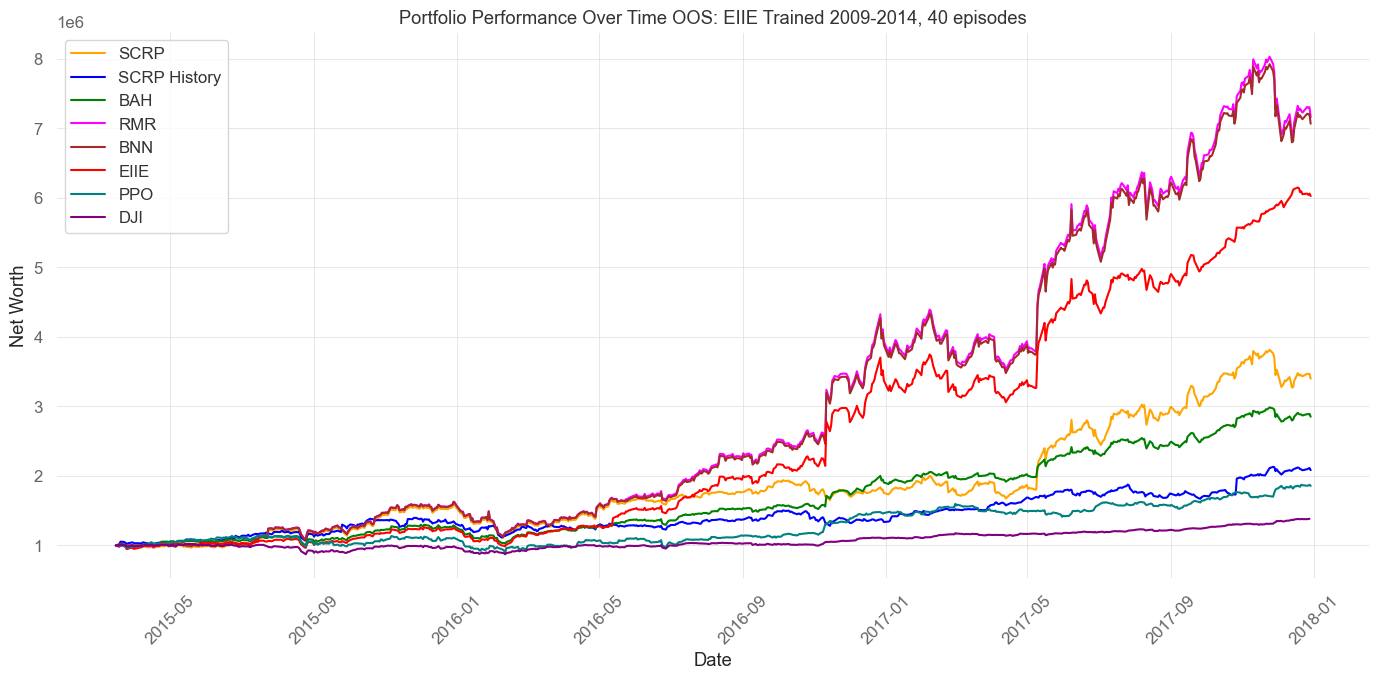

In [ ]:
# Use the correct backend for Jupyter
%matplotlib inline
import matplotlib.pyplot as plt


import matplotlib.pyplot as plt

# Define a color map for the labels
color_map = {
    'BAH': 'green',
    'EIIE': 'red',
    'PPO': 'teal',
    'DJI': 'purple',
    'SCRP': 'orange',
    'SCRP History': 'blue',
    'OLMAR': 'cyan',
    'RMR': 'magenta',
    'BNN': 'brown'
}




plt.figure(figsize=(14, 7))
# plt.plot(merged_df['Date'], merged_df['crp_opt_net_worth'], label='CRP', color=color_map['CRP'])
plt.plot(merged_df['Date'], merged_df['scrp_opt_net_worth'], label='SCRP', color=color_map['SCRP'])
plt.plot(merged_df['Date'], merged_df['scrp_hist_opt_net_worth'], label='SCRP History', color=color_map['SCRP History'])
plt.plot(merged_df['Date'], merged_df['bah_opt_net_worth'], label='BAH', color=color_map['BAH'])
# plt.plot(merged_df['Date'], merged_df['olmar_opt_net_worth'], label='OLMAR', color=color_map['OLMAR'])
plt.plot(merged_df['Date'], merged_df['rmr_opt_net_worth'], label='RMR', color=color_map['RMR'])
plt.plot(merged_df['Date'], merged_df['bnn_opt_net_worth'], label='BNN', color=color_map['BNN'])
plt.plot(merged_df['Date'], merged_df['eiie_net_worth'], label='EIIE', color=color_map['EIIE'])
plt.plot(merged_df['Date'], merged_df['ppo_opt_net_worth'], label='PPO', color=color_map['PPO'])
plt.plot(merged_df['Date'], merged_df['dji'], label='DJI', color=color_map['DJI'])
plt.xlabel('Date')
plt.ylabel('Net Worth')
plt.title('Portfolio Performance Over Time OOS: ' + GRAPH_TITLE)
plt.legend()
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

In [95]:
import pprint

final_returns = {
   'BCRP OPT': merged_df['bcrp_opt_net_worth'].iloc[-1],
    'CRP': merged_df['crp_opt_net_worth'].iloc[-1],
    'SCRP': merged_df['scrp_opt_net_worth'].iloc[-1],
    'Hist. SCRP': merged_df['scrp_hist_opt_net_worth'].iloc[-1],
    'BAH': merged_df['bah_opt_net_worth'].iloc[-1],
    'OLMAR': merged_df['olmar_opt_net_worth'].iloc[-1],
    'RMR': merged_df['rmr_opt_net_worth'].iloc[-1],
    'BNN': merged_df['bnn_opt_net_worth'].iloc[-1],
    'EIIE': merged_df['eiie_net_worth'].iloc[-1],
    'PPO': merged_df['ppo_opt_net_worth'].iloc[-1],
}

pprint.pprint(final_returns)

{'BAH': 2850360.5,
 'BCRP OPT': 8646465.0,
 'BNN': 7065125.0,
 'CRP': 2171344.0,
 'EIIE': 6025591.5,
 'Hist. SCRP': 2081930.0,
 'OLMAR': 809758.5625,
 'PPO': 1855729.5,
 'RMR': 7159755.0,
 'SCRP': 3399345.5}


In [ ]:
import numpy as np
import pprint

# Calculate the returns each day

# merged_df['BCRP_daily_return'] = merged_df['BCRP_net_worth'].pct_change()
# merged_df['CRP_daily_return'] = merged_df['CRP_net_worth'].pct_change()
merged_df['BCRP_opt_daily_return'] = merged_df['bcrp_opt_net_worth'].pct_change()
merged_df['CRP_opt_daily_return'] = merged_df['crp_opt_net_worth'].pct_change()
merged_df['SCRP_opt_daily_return'] = merged_df['scrp_opt_net_worth'].pct_change()
merged_df['SCRP_hist_opt_daily_return'] = merged_df['scrp_hist_opt_net_worth'].pct_change()


merged_df['BAH_opt_daily_return'] = merged_df['bah_opt_net_worth'].pct_change()
merged_df['OLMAR_opt_daily_return'] = merged_df['olmar_opt_net_worth'].pct_change()
merged_df['RMR_opt_daily_return'] = merged_df['rmr_opt_net_worth'].pct_change()
merged_df['BNN_opt_daily_return'] = merged_df['bnn_opt_net_worth'].pct_change()

merged_df['EIIE_daily_return'] = merged_df['eiie_net_worth'].pct_change()
merged_df['PPO_daily_return'] = merged_df['ppo_opt_net_worth'].pct_change()


# merged_df['OLMAR_daily_return'] = merged_df['OLMAR_net_worth'].pct_change()


# Define the risk-free rate (annual, for example, 2%)
risk_free_rate = 0.02 / 252  # Convert annual risk-free rate to daily

# Define a function to calculate Sharpe ratio adjusted for the risk-free rate
def calculate_sharpe_ratio(returns, risk_free_rate):
    excess_return = returns - risk_free_rate
    mean_excess_return = excess_return.mean()
    std_excess_return = excess_return.std()
    annual_factor = np.sqrt(252)  # Assuming 252 trading days in a year
    sharpe_ratio = annual_factor * mean_excess_return / std_excess_return
    return sharpe_ratio

# Calculate the Sharpe ratio for each daily return column
sharpe_ratios = {
    # 'BCRP': calculate_sharpe_ratio(merged_df['BCRP_daily_return'], risk_free_rate),
    # 'CRP': calculate_sharpe_ratio(merged_df['CRP_daily_return'], risk_free_rate),
    'BCRP': calculate_sharpe_ratio(merged_df['BCRP_opt_daily_return'], risk_free_rate),
    'CRP': calculate_sharpe_ratio(merged_df['CRP_opt_daily_return'], risk_free_rate),
    'SCRP': calculate_sharpe_ratio(merged_df['SCRP_opt_daily_return'], risk_free_rate),
    'Hist. SCRP': calculate_sharpe_ratio(merged_df['SCRP_hist_opt_daily_return'], risk_free_rate),
    'BAH': calculate_sharpe_ratio(merged_df['BAH_opt_daily_return'], risk_free_rate),
    'OLMAR': calculate_sharpe_ratio(merged_df['OLMAR_opt_daily_return'], risk_free_rate),
    'RMR': calculate_sharpe_ratio(merged_df['RMR_opt_daily_return'], risk_free_rate),
    'BNN': calculate_sharpe_ratio(merged_df['BNN_opt_daily_return'], risk_free_rate),
    'EIIE': calculate_sharpe_ratio(merged_df['EIIE_daily_return'], risk_free_rate),
    'PPO': calculate_sharpe_ratio(merged_df['PPO_daily_return'], risk_free_rate),
    # 'OLMAR old': calculate_sharpe_ratio(merged_df['OLMAR_daily_return'], risk_free_rate),
    # 'Opt': calculate_sharpe_ratio(merged_df['opt_daily_return'], risk_free_rate),

}

pprint.pprint(sharpe_ratios)

{'BAH': 1.8488700118877661,
 'BCRP': 2.0052332841876868,
 'BNN': 1.89906115829114,
 'CRP': 1.6953069894167037,
 'EIIE': 2.0242394225575,
 'Hist. SCRP': 1.2087859155116314,
 'OLMAR': -0.19471288481056126,
 'PPO': 1.0676633426775668,
 'RMR': 1.9057016523012906,
 'SCRP': 1.4342419306179404}


In [97]:
import pandas as pd
import numpy as np

# Assuming merged_df is your DataFrame
# Calculate the max drawdown for each specified column
def max_drawdown(series):
    cumulative_returns = series.cummax()
    drawdowns = series / cumulative_returns - 1
    max_drawdown_value = drawdowns.min()
    return max_drawdown_value

max_drawdowns = {
    # 'BCRP': max_drawdown(merged_df['BCRP_net_worth']),
    # 'CRP': max_drawdown(merged_df['CRP_net_worth']),
    'BCRP': max_drawdown(merged_df['bcrp_opt_net_worth']),
    'CRP': max_drawdown(merged_df['crp_opt_net_worth']),
    'SCRP': max_drawdown(merged_df['scrp_opt_net_worth']),
    'Hist. SCRP': max_drawdown(merged_df['scrp_hist_opt_net_worth']),
    'BAH': max_drawdown(merged_df['bah_opt_net_worth']),
    'OLMAR': max_drawdown(merged_df['olmar_opt_net_worth']),
    'RMR': max_drawdown(merged_df['rmr_opt_net_worth']),
    'BNN': max_drawdown(merged_df['bnn_opt_net_worth']),
    'EIIE': max_drawdown(merged_df['eiie_net_worth']),
    'PPO': max_drawdown(merged_df['ppo_opt_net_worth']),
    # 'Opt': max_drawdown(merged_df['opt_net_worth']),
}

pprint.pprint(max_drawdowns)


{'BAH': -0.20971406542407167,
 'BCRP': -0.2527408524281234,
 'BNN': -0.3053445381515437,
 'CRP': -0.20120393524489477,
 'EIIE': -0.21742791948499696,
 'Hist. SCRP': -0.20254978761923093,
 'OLMAR': -0.35080439916065687,
 'PPO': -0.2287178915120136,
 'RMR': -0.3053444413816482,
 'SCRP': -0.30534438383588314}


In [98]:
import numpy as np
import pandas as pd

# Define a function to calculate the ratio of up days
def calculate_up_days_ratio(series):
    up_days = (series > 0).sum()
    total_days = series.count()
    return up_days / total_days if total_days > 0 else 0

# Calculate the ratio of up days for each daily return column
up_days_ratios = {
    'BCRP': calculate_up_days_ratio(merged_df['BCRP_opt_daily_return']),
    'CRP': calculate_up_days_ratio(merged_df['CRP_opt_daily_return']),
    'SCRP': calculate_up_days_ratio(merged_df['SCRP_opt_daily_return']),
    'Hist. SCRP': calculate_up_days_ratio(merged_df['SCRP_hist_opt_daily_return']),
    'BAH': calculate_up_days_ratio(merged_df['BAH_opt_daily_return']),
    'OLMAR': calculate_up_days_ratio(merged_df['OLMAR_opt_daily_return']),
    'RMR': calculate_up_days_ratio(merged_df['RMR_opt_daily_return']),
    'BNN': calculate_up_days_ratio(merged_df['BNN_opt_daily_return']),
    'EIIE': calculate_up_days_ratio(merged_df['EIIE_daily_return']),
    'PPO': calculate_up_days_ratio(merged_df['PPO_daily_return']),
}

pprint.pprint(up_days_ratios)




{'BAH': 0.5687943262411348,
 'BCRP': 0.5560283687943263,
 'BNN': 0.5418439716312057,
 'CRP': 0.5687943262411348,
 'EIIE': 0.5716312056737589,
 'Hist. SCRP': 0.5361702127659574,
 'OLMAR': 0.4978723404255319,
 'PPO': 0.5106382978723404,
 'RMR': 0.550354609929078,
 'SCRP': 0.548936170212766}


In [99]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from statsmodels.formula.api import ols


# TODO can we do a statisitical significance test with anova here?
ANOVA_cols = ['EIIE_daily_return', 'BAH_opt_daily_return']
cols = ['Date',] + ANOVA_cols


df_selected = merged_df[cols]

# Assuming merged_df is your DataFrame and daily returns have already been calculated
# Combine all return columns into one DataFrame for ANOVA
returns_long = df_selected.melt(
    id_vars=['Date'], 
    value_vars=ANOVA_cols,
    var_name='Portfolio', 
    value_name='Daily_Return'
)

# Remove any NaN values created by pct_change()
returns_long.dropna(inplace=True)

# Perform ANOVA
model = ols('Daily_Return ~ Portfolio', data=returns_long).fit()
anova_result = sm.stats.anova_lm(model, typ=2)

# Display the summary of the ANOVA
pprint.pprint(anova_result)

# The results do seem to be statisitcally significant


             sum_sq      df        F    PR(>F)
Portfolio  0.000501     1.0  1.65535  0.198444
Residual   0.426144  1408.0      NaN       NaN


In [100]:
from scipy import stats

df_ppo = merged_df['EIIE_daily_return'].dropna() 
df_bah = merged_df['BAH_opt_daily_return'].dropna()

print(df_bah)

t_stat, p_value = stats.ttest_ind(df_ppo, df_bah) 

print(f"t-statistic: {t_stat}") 
print(f"p-value: {p_value}")

1      0.000156
2      0.005325
3      0.000674
4      0.016764
5     -0.007854
         ...   
701   -0.004908
702    0.006781
703   -0.000659
704    0.002203
705   -0.014353
Name: BAH_opt_daily_return, Length: 705, dtype: float64
t-statistic: 1.2866039684073476
p-value: 0.1984438585810075
